<img src=../figures/Brown_logo.svg width=50%>

## Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Lecture Variational Inference

### Miguel A. Bessa | <a href = "mailto: miguel_bessa@brown.edu">miguel_bessa@brown.edu</a>  | Associate Professor

## Outline for today

* What is variational inference?
* How to apply variational inference to train BNN?

**Reading material**: This notebook + (Murphy's advanced book, chapter Part II Inference)

## The goal of inference 

- The goal of inference is to approximate a target distribution
 <img align=center src="./figures/INFERENCE.png" width=40%>

- As introduced previously, MCMC-based sampling approaches try to explore the target distribution.
- **Variational inference tries to use a parametric distribution to approach the target distribution**

## Variational objective
- **Objective of variational inference**

    Use another distribution $q(\theta)$ to approximate the posterior $p(\theta|\mathcal{D})$

 <img align=center src="./figures/variational_inference_schematic.png" width=30%>

- **Optimization objective** 

$$q = \arg \min_{q \in \Omega} \mathrm{D}_\mathbb{KL} \left(q(\theta||p(\theta|\mathcal{D}) \right)  $$

---
[1] Murphy, K. P. (2023). Probabilistic machine learning: Advanced topics. MIT press.

### Transformation of variational objective 

In practice, $\psi$ is used as the **variational parameter** from a parametric family $\Omega$, and obtained by 

$$
\begin{align}
	\label{eq:vi_inference_equation}
    \psi^* & = \arg \min_{\psi} \mathrm{D}_\mathbb{KL} \left(q_{\psi}(\boldsymbol{\theta})||p_\theta(\boldsymbol{\theta}|\mathcal{D}) \right)                                                                               \\
           & =  \arg \min_{\psi} \mathbb{E}_{q_\psi(\boldsymbol{\theta})} \left[\log q_\psi(\boldsymbol{\theta}) - \log p_\theta (\boldsymbol{\theta}|\mathcal{D}) \right]                                                          \\
           & =  \arg \min_{\psi} \mathbb{E}_{q_\psi(\boldsymbol{\theta})} \left[\log q_\psi(\boldsymbol{\theta}) - \log
    \left(\frac{p_\theta(\mathcal{D}|\boldsymbol{\theta})p_\theta(\boldsymbol{\theta})}{p_\theta(\mathcal{D})} \right) \right]                                                                                              \\
           & =  \arg \min_{\psi} \mathbb{E}_{q_\psi(\boldsymbol{\theta})} \left[\log q_\psi(\boldsymbol{\theta}) - \log p_\theta(\mathcal{D}|\boldsymbol{\theta}) - \log p_\theta(\boldsymbol{\theta}) +\log p_\theta(\mathcal{D}) \right]  \\
           & =  \arg \min_{\psi} \mathbb{E}_{q_\psi(\boldsymbol{\theta})} \left[\log q_\psi(\boldsymbol{\theta}) - \log p_\theta(\mathcal{D}|\boldsymbol{\theta}) - \log p_\theta(\boldsymbol{\theta})  \right] +\log p_\theta(\mathcal{D})
\end{align}
$$



The final term is not related to $\psi$; therefore, we only need to optimize the first term: 
$$ \begin{align}
    \psi^* & = \arg \min_{\psi} \mathbb{E}_{q_\psi(\boldsymbol{\theta})} \left[\log q_\psi(\boldsymbol{\theta}) - \log p_\theta(\mathcal{D}|\boldsymbol{\theta}) - \log p_\theta(\boldsymbol{\theta})  \right]                      \\
           & = \arg \min_{\psi} \mathbb{E}_{q_\psi(\boldsymbol{\theta})} \left[ - \log p_\theta(\mathcal{D}|\boldsymbol{\theta})\right] + \mathrm{D}_{\mathbb{KL}}(q_{\psi}(\boldsymbol{\theta})|| p_\theta(\boldsymbol{\theta})) \
\end{align} $$

- The objective is called **negative evidence lower bound (ELBO)**

### Let's dive into the objective of ELBO
$$\psi^*   = \arg \min_{\psi} \mathbb{E}_{q_\psi(\boldsymbol{\theta})} \left[ - \log p_\theta(\mathcal{D}|\boldsymbol{\theta})\right] + \mathrm{D}_{\mathbb{KL}}(q_{\psi}(\boldsymbol{\theta})|| p_\theta(\boldsymbol{\theta}))  $$

- The first term is the negative likelihood dominated by **Data**
- The second term is KL divergence between the **estimated distribution** and the **prior distribution**
- It means that by mimizing ELBO, it tends to find an estimated distribution not only fits the data, but also as close to the prior distribution as it can be. 

###  One dimension numerical Gaussian mixture distribution 


In [1]:
# import libraries
import torch
import math
import copy
import matplotlib.pyplot as plt 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
class TargetDistribution:

    def __init__(self,  w1=0.3,w2=0.7,  mu1=-2,  sigma1=1, mu2=2, sigma2=1) -> None:
        self.w1 = w1
        self.w2 = w2
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.mu2 = mu2
        self.sigma2 = sigma2


    def pdf(self, x) -> float:
        return self.w1 * self.gaussian(x, self.mu1, self.sigma1) + \
            self.w2 * self.gaussian(x, self.mu2, self.sigma2)

    # sample from the distribution
    def sample(self, num_samples=1000):
        samples = []
        for _ in range(num_samples):
            if np.random.rand() < self.w1:
                samples.append(np.random.normal(self.mu1, self.sigma1))
            else:
                samples.append(np.random.normal(self.mu2, self.sigma2))
        return np.array(samples)
    
    def plot_pdf(self):
        fig, ax = plt.subplots(figsize=(5, 4))
        x = np.linspace(-10, 10, 1000)
        y = self.pdf(x)
        ax.plot(x, y)
        ax.set_xlabel('x')
        ax.set_ylabel('pdf')
        plt.show()

    @ staticmethod
    def gaussian(x, mu, sigma) -> float:
        return 1.0/(np.sqrt(2 * np.pi)) * np.exp(- ( x- mu)**2 / 2*sigma**2)


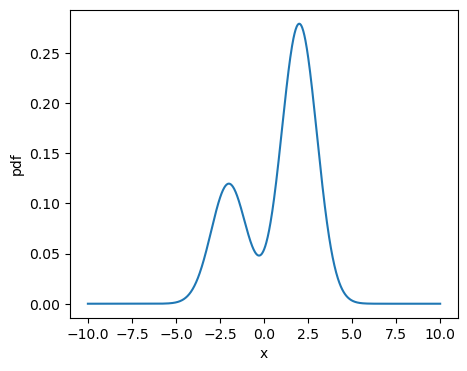

In [2]:
dis = TargetDistribution()
dis.plot_pdf()


In [3]:
class VariationalInference:

    def __init__(self,
                  target_distribution,
                  prior_mean = torch.tensor([0.0]),
                  prior_covariance = torch.tensor([[2.0]]),
                  num_samples=1000,
                  proposed_mean = torch.tensor([0.0], requires_grad=True),
                  proposed_covariance = torch.tensor([1.0], requires_grad=True)
                  ) -> None:
        self.target_distribution = target_distribution
        self.samples = torch.tensor(target_distribution.sample(num_samples),
                                    dtype=torch.float32, requires_grad=True)
        self.num_samples = num_samples
        # prior mean and covariance
        self.prior_mean = prior_mean.detach()
        self.prior_covariance = prior_covariance.detach()
        # proposed params (mean, variance)
        self.proposed_mean = proposed_mean
        self.proposed_covariance = proposed_covariance

        # history containers
        self.neg_log_lik_hist = []

    def define_optimizer(self, optimizer_name="Adam", learning_rate=0.01):
        params = [self.proposed_mean, self.proposed_covariance]
        if optimizer_name == "Adam":
            self.optimizer = torch.optim.Adam(params, lr=learning_rate)
        elif optimizer_name == "SGD":
            self.optimizer = torch.optim.SGD(params, lr=learning_rate)
        else:
            raise ValueError("Optimizer not implemented yet.")
    
    def run(self, n_epochs=1000):
        self.neg_log_lik_hist = []  # reset history

        for step in range(n_epochs):
            self.optimizer.zero_grad()

            # variance (>=0) 
            var = self.proposed_covariance
            std = torch.sqrt(var + 1e-12)

            # Negative log-likelihood (Monte Carlo on fixed data samples)
            nll = -torch.distributions.Normal(self.proposed_mean, scale=std)\
                    .log_prob(self.samples).mean()

            # KL(q||p) between two 1D Gaussians
            kl = 0.5 * (
                (var / self.prior_covariance) +
                ((self.prior_mean - self.proposed_mean)**2 / self.prior_covariance) -
                1 + torch.log(self.prior_covariance / (var + 1e-12))
            )
            kl = kl.mean()

            # ELBO objective to minimize: nll + KL
            elbo = nll + kl

            elbo.backward()
            self.optimizer.step()

            # record
            self.neg_log_lik_hist.append(float(nll.detach()))

            if step % 10 == 0:
                print("=====================================")
                print(f"Step {step}: Neg Log Likelihood = {nll.item():.4f}")
                print(f"Step {step}: ELBO = {elbo.item():.4f}")
                print(f"Mean = {self.proposed_mean.detach().cpu().numpy()}")
                print(f"Variance = {var.detach().cpu().numpy()}")

        return self.proposed_mean.detach().cpu().numpy(), var.detach().cpu().numpy()
    
    def plot_results(self):
        # estimated params
        estimated_mean = float(self.proposed_mean.detach())
        estimated_var  = float(self.proposed_covariance.detach())
        estimated_std  = float(np.sqrt(max(estimated_var, 1e-12)))

        # PDFs
        x = torch.linspace(-10, 10, 1000)
        true_pdf = self.target_distribution.pdf(x).detach().cpu().numpy()
        x_np = x.detach().cpu().numpy()
        est_pdf = (1.0 / (np.sqrt(2*np.pi) * estimated_std)) * \
                  np.exp(-0.5 * ((x_np - estimated_mean) / estimated_std) ** 2)
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Left: PDFs
        axes[0].plot(x_np, true_pdf, 'r--', label="True PDF")
        axes[0].plot(x_np, est_pdf,  'k-',  label="Estimated PDF")
        axes[0].set_xlim(-10, 10)
        axes[0].set_xlabel("x"); axes[0].set_ylabel("Density")
        axes[0].set_title("Variational Inference (1D)")
        axes[0].legend()

        # Right: NLL history
        if hasattr(self, "neg_log_lik_hist") and len(self.neg_log_lik_hist) > 0:
            axes[1].plot(np.arange(len(self.neg_log_lik_hist)), self.neg_log_lik_hist)
            axes[1].set_xlabel("Epoch")
            axes[1].set_ylabel("Negative Log-Likelihood")
            axes[1].set_title("NLL over Epochs")
        else:
            axes[1].text(0.5, 0.5, "Run VI first to collect NLL", ha='center', va='center')
            axes[1].set_axis_off()

        plt.tight_layout()
        plt.show()


### Use VI to obtain a parametric distribution for the target distribution

In [4]:
# play with the paramters
vi = VariationalInference(target_distribution=dis,
                           prior_mean=torch.tensor([0.0]),
                            prior_covariance=torch.tensor([1.0]),
                            num_samples=100000)
vi.define_optimizer(optimizer_name="SGD", learning_rate=0.1)
estimated_mean, estimated_covariance = vi.run(n_epochs=300)


Step 0: Neg Log Likelihood = 3.4176
Step 0: ELBO = 3.4176
Mean = [0.08081859]
Variance = [1.1998653]
Step 10: Neg Log Likelihood = 2.5321
Step 10: ELBO = 2.6597
Mean = [0.27505454]
Variance = [1.75697]
Step 20: Neg Log Likelihood = 2.4478
Step 20: ELBO = 2.6217
Mean = [0.28031617]
Variance = [1.9351692]
Step 30: Neg Log Likelihood = 2.4171
Step 30: ELBO = 2.6125
Mean = [0.27213797]
Variance = [2.025417]
Step 40: Neg Log Likelihood = 2.4021
Step 40: ELBO = 2.6095
Mean = [0.26591277]
Variance = [2.0765617]
Step 50: Neg Log Likelihood = 2.3938
Step 50: ELBO = 2.6085
Mean = [0.26206928]
Variance = [2.1069765]
Step 60: Neg Log Likelihood = 2.3890
Step 60: ELBO = 2.6081
Mean = [0.2597567]
Variance = [2.1255136]
Step 70: Neg Log Likelihood = 2.3860
Step 70: ELBO = 2.6080
Mean = [0.2583545]
Variance = [2.1369681]
Step 80: Neg Log Likelihood = 2.3842
Step 80: ELBO = 2.6079
Mean = [0.25749415]
Variance = [2.144104]
Step 90: Neg Log Likelihood = 2.3831
Step 90: ELBO = 2.6079
Mean = [0.2569611]
Va

/tmp/ipykernel_35044/399156165.py:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1.0/(np.sqrt(2 * np.pi)) * np.exp(- ( x- mu)**2 / 2*sigma**2)


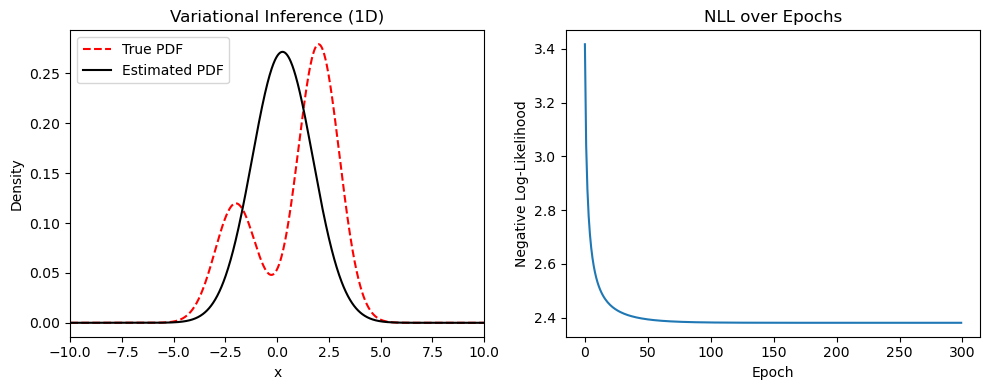

In [5]:
vi.plot_results()

### When VI meets neural networks
**Recall the one-dimensional regression problem**



In [6]:
## Define a one-dimensional problem 
torch.manual_seed(0)  # fix the seed
def cubic_sin(x: torch.Tensor,
              noise_std: float = 0.1) -> torch.Tensor:
    """dis continuous function with noise"""

    obj = torch.sin(6*x)**3 + torch.randn_like(x) * noise_std

    return obj.reshape((-1, 1))
# get the training samples
sample_x1 = torch.linspace(-0.8, -0.2, 16).reshape((-1, 1))
sample_x2 = torch.linspace(0.2, 0.8, 16).reshape((-1, 1))
sample_x = torch.cat([sample_x1, sample_x2], dim=0)
# scale the data
x_mean = sample_x.mean(); x_std = sample_x.std()
sample_x_scaled = (sample_x - x_mean) / x_std
# get the responses
sample_y = cubic_sin(sample_x, noise_std=0.1)
# scale the y
y_mean = sample_y.mean(); y_std = sample_y.std()
sample_y_scaled = (sample_y - y_mean) / y_std

### Define a variational layer for neural network

In [7]:

class VariationalLinear(nn.Module):
    """Define one VI layer"""
    def __init__(self, in_features, out_features, prior_mu, prior_sigma):
        super().__init__()
        self.weight_mu  = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.empty(out_features, in_features))
        self.bias_mu    = nn.Parameter(torch.empty(out_features))
        self.bias_rho   = nn.Parameter(torch.empty(out_features))
        self.reset_parameters()
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
    def _sigma(self, rho):
        return F.softplus(rho) # make sure variance is larger than zero 

    def forward(self, x):
        eps_w = torch.randn_like(self.weight_mu)
        eps_b = torch.randn_like(self.bias_mu)
        weight = self.weight_mu + self._sigma(self.weight_rho) * eps_w
        bias   = self.bias_mu   + self._sigma(self.bias_rho)   * eps_b
        return F.linear(x, weight, bias)

    def kl_divergence(self):
        # posterior parameters
        sigma_w_q = self._sigma(self.weight_rho)
        sigma_b_q = self._sigma(self.bias_rho)
        mu_w_q = self.weight_mu
        mu_b_q = self.bias_mu
        # prior parameters (broadcast)
        mu_p = self.prior_mu; sigma_p = self.prior_sigma
        kl_w = torch.log(sigma_p / sigma_w_q) \
               + (sigma_w_q.pow(2) + (mu_w_q - mu_p).pow(2)) / (2 * sigma_p**2) \
               - 0.5
        kl_b = torch.log(sigma_p / sigma_b_q) \
               + (sigma_b_q.pow(2) + (mu_b_q - mu_p).pow(2)) / (2 * sigma_p**2) \
               - 0.5
        return kl_w.sum() + kl_b.sum()
    
    def reset_parameters(self) -> None:
        layer_width = math.sqrt(self.weight_mu.size(1))
        self.weight_mu.data.uniform_(-layer_width, layer_width)
        self.weight_rho.data.uniform_(-layer_width, layer_width)
        self.bias_mu.data.uniform_(-layer_width, layer_width)
        self.bias_rho.data.uniform_(-layer_width, layer_width)

### Assemble a MLP with multiple layers

In [8]:
class BNN_VI(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, prior_mu, prior_sigma):
        super().__init__()
        self.fc1 = VariationalLinear(input_dim,  hidden_dim, prior_mu, prior_sigma)
        self.fc2 = VariationalLinear(hidden_dim, hidden_dim, prior_mu, prior_sigma)
        self.fc3 = VariationalLinear(hidden_dim, output_dim, prior_mu, prior_sigma)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

    def kl_divergence(self):
        return self.fc1.kl_divergence() + self.fc2.kl_divergence() + self.fc3.kl_divergence()

network = BNN_VI(input_dim=1, hidden_dim=10, output_dim=1, prior_mu=0.0, prior_sigma=1.0)
# print number of params
print("Number of params:", sum(p.numel() for p in network.parameters()))

Number of params: 282


### Training routine of VI for BNN 

In [9]:
# ---------- Gaussian NLL (sum reduction), fixed homoscedastic noise ----------
def gaussian_nll_sum(y_pred, y_true, noise_var):
    inv_var = 1.0 / noise_var
    log_var = torch.log(noise_var)
    nll = 0.5 * ((y_true - y_pred) ** 2 * inv_var + log_var)  # no constant term
    return nll.sum()

class VITrainer:
    def __init__(self, net, noise_var):
        self.net = net
        self.noise_var = noise_var
        self.optimizer = None

    def configure_optimizer_info(self, optimizer_name="Adam", lr=1e-3):
        if optimizer_name == "Adam":
            self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        elif optimizer_name == "SGD":
            self.optimizer = torch.optim.SGD(self.net.parameters(), lr=lr)

    def train(self, x, y, num_epochs, num_integral=10, verbose=True, print_every=10):
        N = x.shape[0]
        self.num_epochs = num_epochs
        self.nll_loss_train = np.zeros(num_epochs)
        self.kl_loss_train  = np.zeros(num_epochs)
        self.total_loss     = np.zeros(num_epochs)
        self.best_loss_epoch= np.zeros(num_epochs)
        self.best_net, self.best_loss = None, float("inf")

        for epoch in range(num_epochs):
            self.optimizer.zero_grad()
            nll_integral = 0.0
            for _ in range(num_integral):
                self.net.train()         
                yhat = self.net(x)
                nll  = gaussian_nll_sum(yhat, y, self.noise_var)
                nll_integral += nll
            nll_integral = nll_integral / num_integral

            # KL term
            kl_loss = self.net.kl_divergence()

            # ELBO loss = E_q[NLL] + KL
            loss = nll_integral - kl_loss
            loss.backward()
            self.optimizer.step()

            # Record
            self.nll_loss_train[epoch] = nll_integral.item()
            self.kl_loss_train[epoch]  = kl_loss.item()
            self.total_loss[epoch]     = loss.item()

            # Keep best by NLL
            if self.nll_loss_train[epoch] < self.best_loss:
                self.best_loss = self.nll_loss_train[epoch]
                self.best_net  = copy.deepcopy(self.net)
            self.best_loss_epoch[epoch] = self.best_loss

            if verbose and ((epoch + 1) % print_every == 0 or epoch == 0):
                self._print(epoch, N)

    @torch.no_grad()
    def predict(self, x, num_integral=30, save_ppd=False):
        self.best_net.eval()
        responses = []
        for _ in range(num_integral):
            self.best_net.train()   # force sampling
            y_pred = self.best_net(x)
            self.best_net.eval()
            responses.append(y_pred)
        stack = torch.stack(responses, dim=0) 
        y_pred = stack.mean(dim=0)
        y_epistemic_var = stack.var(dim=0, unbiased=False)

        if save_ppd:
            self.responses = responses
        return y_pred,  y_epistemic_var

    def _print(self, iteration, N):
        print("==================================================")
        print(f"epoch: {iteration + 1:5d}/{self.num_epochs:5d}")
        print(f"nll_loss: {self.nll_loss_train[iteration]:.3f}, "
              f"kl_loss: {self.kl_loss_train[iteration]:.3f}, "
              f"total: {self.total_loss[iteration]:.3f}")
        print(f"best_loss: {self.best_loss:.4f}")
        print(f"noise_var: {self.noise_var}")

In [25]:
trainer = VITrainer(net=network, noise_var=torch.tensor(0.01)/y_std**2)
trainer.configure_optimizer_info("Adam", lr=1e-3)
trainer.train(
    x=sample_x_scaled,
    y=sample_y_scaled,
    num_epochs=2000,
    num_integral=10,
    verbose=True,
    print_every=100,
)


epoch:     1/ 2000
nll_loss: 103.013, kl_loss: 9576.181, total: -9473.168
best_loss: 103.0126
noise_var: 0.026290807873010635
epoch:   100/ 2000
nll_loss: 94.704, kl_loss: 9742.526, total: -9647.822
best_loss: 67.2778
noise_var: 0.026290807873010635
epoch:   200/ 2000
nll_loss: 95.012, kl_loss: 9912.540, total: -9817.527
best_loss: 66.8363
noise_var: 0.026290807873010635
epoch:   300/ 2000
nll_loss: 82.077, kl_loss: 10084.763, total: -10002.686
best_loss: 65.6516
noise_var: 0.026290807873010635
epoch:   400/ 2000
nll_loss: 78.714, kl_loss: 10259.251, total: -10180.537
best_loss: 65.6516
noise_var: 0.026290807873010635
epoch:   500/ 2000
nll_loss: 79.190, kl_loss: 10435.873, total: -10356.683
best_loss: 65.6516
noise_var: 0.026290807873010635
epoch:   600/ 2000
nll_loss: 84.309, kl_loss: 10614.832, total: -10530.523
best_loss: 65.2734
noise_var: 0.026290807873010635
epoch:   700/ 2000
nll_loss: 79.688, kl_loss: 10796.042, total: -10716.354
best_loss: 65.2734
noise_var: 0.026290807873010

In [26]:

def plot_prediction():
    test_x = torch.linspace(-1, 1, 100).reshape((-1, 1))
    # scale 
    test_x_scaled = (test_x-x_mean)/x_std.numpy()
    test_y = cubic_sin(test_x, noise_std=0)  # ground truth

    # code here to visualize your result
    pred_mean, epistemic = trainer.predict(test_x_scaled,num_integral=1000)
    # scale it back 
    pred_mean = pred_mean*y_std.numpy() + y_mean.numpy()
    epistemic = epistemic**0.5*y_std.numpy()
    # plot the result
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(test_x.numpy(), test_y.numpy(),'--', linewidth=2, color='gray',label='True Function')
    ax[0].plot(test_x.numpy(), pred_mean, color='b', label='Prediction')
    ax[0].fill_between(test_x.numpy().reshape(-1), pred_mean.reshape(-1) - 1.96*epistemic.reshape(-1),
                     pred_mean.reshape(-1) + 1.96*epistemic.reshape(-1), alpha=0.2, label='Epistemic')
    ax[0].scatter(sample_x.numpy(), sample_y.numpy(), marker='o', s=40, label='Training Data')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    
    ax[0].legend()
    ax[1].plot(trainer.best_loss_epoch, 'o')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('NLL')

/tmp/ipykernel_35044/2402854864.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_x_scaled = (test_x-x_mean)/x_std.numpy()
/tmp/ipykernel_35044/2402854864.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  pred_mean = pred_mean*y_std.numpy() + y_mean.numpy()
/tmp/ipykernel_35044/2402854864.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  epistemic = epistemic**0.5*y_std.numpy()


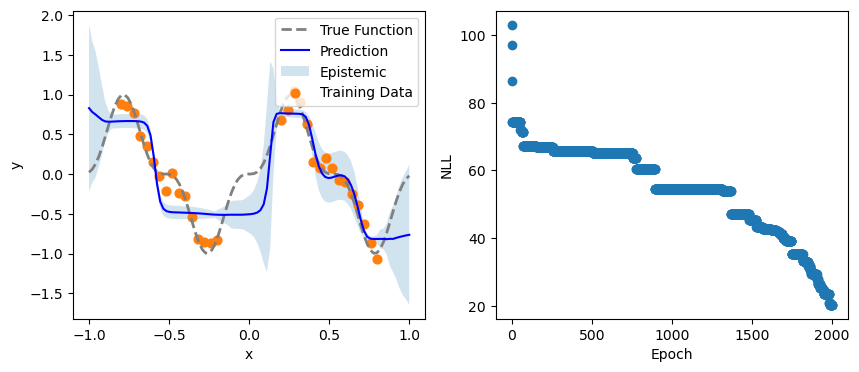

In [27]:
plot_prediction()

### See you next class

Have fun!